In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torchvision import transforms
import tabulate

# Load observations from the mnist dataset. The observations are divided into a training set and a test set
mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True)
x_train = mnist_train.data.reshape(-1, 784).float().cuda()  # Reshape input
y_train = torch.zeros((mnist_train.targets.shape[0], 10)).cuda()  # Create output tensor
y_train[torch.arange(mnist_train.targets.shape[0]), mnist_train.targets] = 1  # Populate output

mnist_test = torchvision.datasets.MNIST('./data', train=False, transform=transforms.ToTensor(),  download=True)
x_test = mnist_test.data.reshape(-1, 784).float().cuda()  # Reshape input
y_test = torch.zeros((mnist_test.targets.shape[0], 10)).cuda()  # Create output tensor
y_test[torch.arange(mnist_test.targets.shape[0]), mnist_test.targets] = 1  # Populate output
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

class MNISTModel:
    def __init__(self):
        # Model variables
        self.w1 = torch.zeros(784, 10, requires_grad=True, device=device)
        #self.w1 = torch.rand(784, 10, requires_grad=True, device=device)
        self.b1 = torch.zeros(10, requires_grad=True, device=device)

  # Predictor
    def f(self, x):
        return torch.nn.functional.softmax(x @ self.w1 + self.b1, dim=1)

    # Uses Cross Entropy
    def loss(self, x, y):
        return torch.nn.functional.binary_cross_entropy_with_logits(self.f(x), y)

model = MNISTModel()

lr = 0.1
epochs = 10000
stepping = 1000
# Optimize: adjust W and b to minimize loss using stochastic gradient descent
optimizer = torch.optim.SGD([model.w1,model.b1], lr)
for i in range(1, epochs):
    loss = model.loss(x_train, y_train) # Compute loss gradients

    if i % stepping == 0:
        print ("iteration: ", i, "loss: ", loss.item(), "accuracy: ", torch.mean(torch.eq(model.f(x_test).argmax(1), y_test.argmax(1)).float()).item())
    loss.backward()

    optimizer.step()  # Perform optimization by adjusting W and b

    optimizer.zero_grad()  # Clear gradients for next step

iteration:  1000 loss:  0.6616791486740112 accuracy:  0.9236999750137329
iteration:  2000 loss:  0.6612317562103271 accuracy:  0.9246999621391296
iteration:  3000 loss:  0.6614572405815125 accuracy:  0.9205999970436096
iteration:  4000 loss:  0.6607750654220581 accuracy:  0.9254999756813049
iteration:  5000 loss:  0.6613228917121887 accuracy:  0.9205999970436096
iteration:  6000 loss:  0.660354495048523 accuracy:  0.9275999665260315
iteration:  7000 loss:  0.6608893871307373 accuracy:  0.9256999492645264
iteration:  8000 loss:  0.6606178879737854 accuracy:  0.9262999892234802
iteration:  9000 loss:  0.6603425741195679 accuracy:  0.9251999855041504


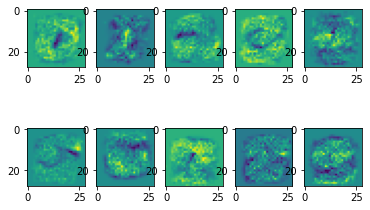

In [6]:
# Show the input of the first observation in the training set

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(model.w1[:, i].cpu().detach().numpy().reshape(28, 28))
    plt.imsave('x_train_' + str(i) + '.png', x_train[0, :].reshape(28, 28).cpu())
# Print the classification of the first observation in the training set


# Save the input of the first observation in the training set


plt.show()

Predicted Digit = 8


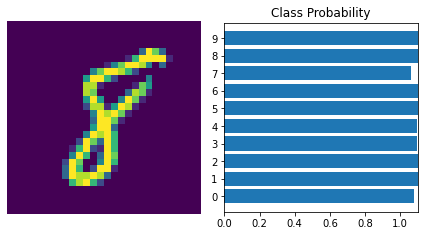

In [7]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

images, labels = next(iter(test_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model.f(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)


In [8]:


correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model.f(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))



Number Of Images Tested = 10000

Model Accuracy = 0.9264
